In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.models import vgg16

In [4]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 加载预训练模型
        self.vgg_model = vgg16(pretrained=True)
        # 改写 预训练模型的部分
        self.classifier = nn.Sequential( nn.Linear(in_features=25088, out_features=100),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5,inplace=False),
                                        nn.Linear( in_features=100, out_features=6 ),
                                        nn.Sigmoid())
        # 把 预训练模型vgg16的classifier换成我们定义的classifier
        self.vgg_model.classifier = self.classifier
        
        # 冻结vgg模型中的参数
        for param in self.vgg_model.parameters():
            param.requires_grad = False
        
        # 把 classifier中的参数设为可训练
        for param in self.vgg_model.classifier.parameters():
            param.requires_grad = True
    
    def forward(self,input):
        output = self.vgg_model(input)
        
        return output

In [5]:
mymodel = MyModel()

In [11]:
# 可视化模型
from torchsummary import summary
summary(model=mymodel,input_size=[(3,100,100)],batch_size=1,device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 100, 100]           1,792
              ReLU-2          [1, 64, 100, 100]               0
            Conv2d-3          [1, 64, 100, 100]          36,928
              ReLU-4          [1, 64, 100, 100]               0
         MaxPool2d-5            [1, 64, 50, 50]               0
            Conv2d-6           [1, 128, 50, 50]          73,856
              ReLU-7           [1, 128, 50, 50]               0
            Conv2d-8           [1, 128, 50, 50]         147,584
              ReLU-9           [1, 128, 50, 50]               0
        MaxPool2d-10           [1, 128, 25, 25]               0
           Conv2d-11           [1, 256, 25, 25]         295,168
             ReLU-12           [1, 256, 25, 25]               0
           Conv2d-13           [1, 256, 25, 25]         590,080
             ReLU-14           [1, 256,

In [6]:
# 数据集
# 使用 torchvision的 datasets.ImageFolder 类 来导入本地数据集
# 使用 torchvision.transform来进行数据增强
# 训练数据集
train_dataset = torchvision.datasets.ImageFolder(root='D:/dataset/fruit_fresh_rotten/train/',
                                                transform=torchvision.transforms.Compose([
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((100,100)),
                                                    torchvision.transforms.RandomHorizontalFlip(),
                                                    torchvision.transforms.RandomRotation(20),
                                                ]))
# 验证数据集
val_dataset = torchvision.datasets.ImageFolder(root='D:/dataset/fruit_fresh_rotten/test/',
                                                transform=torchvision.transforms.Compose([
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((100,100))
                                                ]))


In [7]:
# 数据导入器
# 训练导入器
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
# 验证导入器
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=32,shuffle=True)

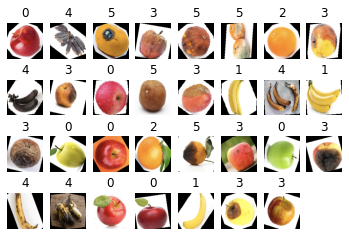

In [6]:
# 可视化 导入器导入的数据
train_iter = iter(train_dataloader)
image,label = train_iter.__next__()
for i in range(31):
    item_image = image[i]
    item_label = label[i]
    item_image = np.transpose(item_image,(1,2,0))
    plt.subplot(4,8,i+1)
    plt.imshow(item_image)
    plt.axis('off')
    plt.title(item_label.item())
plt.show()
plt.close()

In [8]:
# 把数据导入器设置成无限的
def get_infinite_dataloader(dataloader):
    while True:
        for item in dataloader:
            yield item
ifinite_train_dataloader = get_infinite_dataloader(train_dataloader)

In [9]:
# 使用GPU进行训练
# 指定设备
device = torch.device('cuda:0')
# 把模型搬到GPU上
saved_dict = torch.load('mytransferlearning_model_fine_tuned.pth')
mymodel.load_state_dict(saved_dict)
mymodel.to(device)

MyModel(
  (vgg_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [10]:
# 冻结 features 20—30层
for i in range(0,25):
    for param in mymodel.vgg_model.features[i].parameters():
        param.requires_grad = False

for i in range(28,31):
    for param in mymodel.vgg_model.features[i].parameters():
        param.requires_grad = True
        

for param in mymodel.vgg_model.classifier[0].parameters():
        print(param.requires_grad)
        break

True


In [11]:
from tensorboardX import SummaryWriter
# 实例化一个 summarywriter
summary = SummaryWriter('training/train_scalars')

In [12]:
# 训练
total_epoch = 500
optimizer = torch.optim.Adam(mymodel.parameters(),lr=0.0001)
# loss 的 日志
loss_report = []
# 训练轮数的日志
iteration_report = []
# 训练 准确率的日志
train_accuracy_report = []
#验证 准确率的日志
validation_accuracy_report = []

def train():
    mymodel.train()
    # 取数据
    image,label = ifinite_train_dataloader.__next__()
    # 将数据搬到GPU上
    image = image.to(device)
    
    label = label.to(device)
    # 前向传播计算loss
    output = mymodel(image)
    loss = nn.CrossEntropyLoss()(output,label)
    # 把 loss 放到 loss 的日志里面
    loss_report.append(loss.item())
    # 把 loss.item() 记录到 tensorboard 中
    summary.add_scalar('loss',loss.item(),iteration)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 每100轮打印 loss
    if iteration % 50 == 0 :
        # 计算训练集识别准确率（一个batch）
        _,pred = torch.max(output,1)
        correct_item = (pred==label).sum()
        total_item = len(label)
        total_train_accuracy = correct_item / total_item
        # 把 这一轮的训练准确率放入 训练准确率日志
        train_accuracy_report.append(total_train_accuracy.item())
        # 把 这一轮的训练准确率 记录到 tensorboard 中
        summary.add_scalar('train accuracy',total_train_accuracy.item(),iteration)
        # 打印
        print('epoch:',iteration,'','loss:',loss.item(),'','total_train_accuracy:',total_train_accuracy.item())

        
def val():
    mymodel.eval()
    total_item = 0
    correct_item = 0
    for item in val_dataloader:
        # 取出数据，搬到GPU上
        image,label = item
        image = image.to(device)
        label = label.to(device)
        # 计算模型输出
        output = mymodel(image)
        # 取出最大的输出作为结果
        _,pred = torch.max(output,1)

        # 更新总预测数量
        total_item += label.size(0)
        # 如果相等，则预测正确数量+1
        correct_item += (pred==label).sum()
    total_val_accuracy = correct_item / total_item
    print('epoch:',iteration,'','total_val_accuracy:',total_val_accuracy.item())
    # 把这一轮的验证准确率放入验证准确率日志
    validation_accuracy_report.append(total_val_accuracy.item())
    # 把 这一轮的验证准确率放入记录到 tensorboard 中
    summary.add_scalar('val accuracy',total_val_accuracy.item(),iteration)

    
for iteration in range(total_epoch+1):
    iteration_report.append(iteration)
    train()
    if iteration % 50 == 0 :
        val()
# 模型的保存
torch.save(mymodel.state_dict(),'mytransferlearning_model_fine_tuned2.pth')


epoch: 0  loss: 1.7621123790740967  total_train_accuracy: 0.375
epoch: 0  total_val_accuracy: 0.34210526943206787
epoch: 50  loss: 1.6991543769836426  total_train_accuracy: 0.3125
epoch: 50  total_val_accuracy: 0.34210526943206787
epoch: 100  loss: 1.8165137767791748  total_train_accuracy: 0.25
epoch: 100  total_val_accuracy: 0.3417346179485321
epoch: 150  loss: 1.8167426586151123  total_train_accuracy: 0.1875
epoch: 150  total_val_accuracy: 0.34210526943206787
epoch: 200  loss: 1.8005450963974  total_train_accuracy: 0.1875
epoch: 200  total_val_accuracy: 0.34210526943206787
epoch: 250  loss: 1.659576654434204  total_train_accuracy: 0.34375
epoch: 250  total_val_accuracy: 0.34099334478378296
epoch: 300  loss: 1.6602635383605957  total_train_accuracy: 0.34375
epoch: 300  total_val_accuracy: 0.34099334478378296
epoch: 350  loss: 1.7535542249679565  total_train_accuracy: 0.25
epoch: 350  total_val_accuracy: 0.338398814201355
epoch: 400  loss: 1.6991543769836426  total_train_accuracy: 0.28

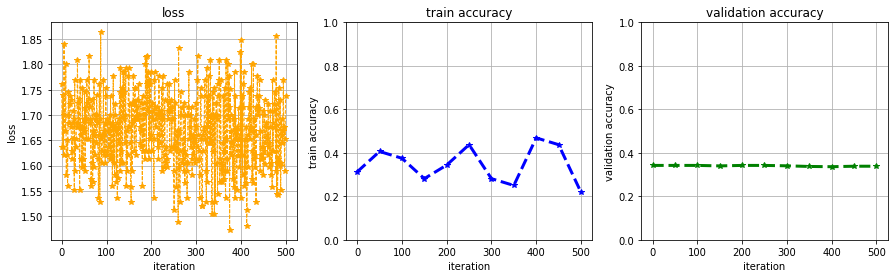

In [19]:
# 模型训练的可视化
#loss-iteration 曲线
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(iteration_report,loss_report,marker="*", linewidth=1, linestyle="--", color="orange")
plt.title('loss')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.grid(True)
# train_accuracy-iteration 曲线
plt.subplot(1,3,2)
plt.plot(iteration_report[::50],train_accuracy_report,marker="*", linewidth=3, linestyle="--", color="blue")
plt.title('train accuracy')
plt.xlabel("iteration")
plt.ylabel("train accuracy")
plt.ylim(ymin=0,ymax=1)
plt.grid(True)
# val_accuracy-iteration 曲线
plt.subplot(1,3,3)
plt.plot(iteration_report[::50],validation_accuracy_report,marker="*", linewidth=3, linestyle="--", color="green")
plt.title('validation accuracy')
plt.xlabel('iteration')
plt.ylabel('validation accuracy')
plt.ylim(ymin=0,ymax=1)
plt.grid(True)
# 展示 三个图
plt.show()
plt.close()

In [27]:
# 将模型的训练的数据存储在txt文件中
# 存储数据函数
# 输入： 需要存储的list， 保存的txt文件名
def log_data(input_list,file_name):
    with open(file_name,'w+') as f:
        for item in input_list:
            f.writelines(str(item)+'\n') 
        f.close()


# 存储数据文件导入函数
# 输入： 文件名， 返回值：列表
def load_log_data(file_name):
    data = []
    with open(file_name,'r') as f:
        for line in f:
            line = line.replace('\n',"")
            data.append(eval(line))
        f.close()

        return data

# 利用写好的记录和导入函数来记录各个值
# iteration_report
log_data(iteration_report,'iteration_report_log.txt')
mm = load_log_data('iteration_report_log.txt')
print(mm)
# loss_report
log_data(loss_report,'loss_report_log.txt')
mm = load_log_data('loss_report_log.txt')
print(mm)
# train_accuracy_report
log_data(train_accuracy_report,'train_accuracy_report_log.txt')
mm = load_log_data('train_accuracy_report_log.txt')
print(mm)
# validation_accuracy_report
log_data(validation_accuracy_report,'validation_accuracy_report_log.txt')
mm = load_log_data('validation_accuracy_report_log.txt')
print(mm)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,